# SIAMESE NETS

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence


import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/kaigorodov/myprojects/MedConcNorm/')

In [2]:
from src.data.class_balancing import class_sampler
from src.support_models.triplet_generator import TripletGenerator
from src.support_models.loss_functions import triplet_loss, identity_loss
from src.support_models.base_model import base_model
from src.support_models.siamese_model_architecture import siamese_model
from src.support_models.siamese_metric_learner import SiameseMetricLearner

from tqdm import tqdm

In [3]:
train = pd.read_csv('../data/interim/cadec/train.csv')
test = pd.read_csv('../data/interim/cadec/test.csv')

In [4]:
train

,term,start,end,sent,text,code,STR,SNMS
0,Sight loss,173,183,Have a 5 month supply but getting off quick!.,"slurring in speech, lower back pain, bloated, ...",10047571,Visual impairment,"['Visual impairment', 'Visual impairment', 'Vi..."
1,gas pains in abdomen,47,54,It lowered my LDL (not enough) but also lowere...,Terrific cramps in legs and awful gas pains in...,10016767,"Flatulence, eructation, and gas pain","['Flatulence, eructation and gas pain', '[D]Fl..."
2,knees hurt,692,696,Doctor is PISSED-----I'M THRILLED !!!.,Over the course of the past year I've experien...,10023477,Knee pain,"['Knee pain', 'Knee pain', 'Knee pain', 'Knee ..."
3,EXTREME nausea,497,511,vomitting - I have to fight to not throw up I ...,vomitting - I have to fight to not throw up I ...,10028813,Nausea,"['Nausea', 'Nausea', 'Nausea', 'Nausea', 'Naus..."
4,frequently unable to think clearly,110,144,"So far my blood tests have been normal, but no...","After three months on Lipitor, I started to fe...",10012805,Difficulty thinking,[]
...,...,...,...,...,...,...,...,...
3515,joint stiffness,21,36,I didn't realize this was the cause until I re...,"Headaches,body aches,joint stiffness,bloating,...",10023230,Joint stiffness,"['Joint stiffness', 'Joint stiffness NOS', 'Jo..."
3516,gas,1244,1247,He took Tums to alliviate stomach upsets and a...,I used to take Provachol (sp?)but I found it c...,10016766,Flatulence,"['Flatulence', 'Flatulence', 'Flatulence', 'Fl..."
3517,stomach pain,424,436,Now I have to see my doctor again to see if I ...,"For the first 8 days of ever taking it, the on...",10042076,Stomach ache,"['Stomach ache', 'Stomach ache', 'Belly ache',..."
3518,Severe elbow pain,31,35,"Severe elbow, arm and shoulder pain.","Severe elbow, arm and shoulder pain.<SENT>It's...",10033371,Pain,"['Pain', 'Pain', 'Pain', 'Pain', 'Pain', 'Pain..."


# create model embedding

In [5]:
from gensim.models import FastText
from gensim.test.utils import common_texts
from gensim.utils import tokenize

sentences = pd.read_csv('../data/interim/cadec/test.csv')['text'].apply(
                lambda x: x.lower().split('<SENT>')).explode().apply(lambda x: list(tokenize(x))).to_list()

In [6]:
embed_dim = 100
nb_words = 3000

ftmodel = FastText(size=embed_dim, window=5, min_count=1)
ftmodel.build_vocab(sentences=sentences)
ftmodel.train(sentences=sentences, total_examples=len(sentences), epochs=10)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=nb_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False
)

tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

nb_words = min(nb_words, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ftmodel[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(3000, 100)

In [7]:
word_seq_train = tokenizer.texts_to_sequences(train['term'])
word_seq_test = tokenizer.texts_to_sequences(test['term'])

In [8]:
max_seq_len = 15

X_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
X_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [9]:
X_train.shape, X_test.shape

((3520, 15), (881, 15))

In [10]:
labels = pd.read_csv('../data/interim/meddra_codes_terms_synonims.csv')
labels = labels['CODE']
meddra_labels = {v:k for k, v in enumerate(labels.unique())}

y_train = train['code'].apply(lambda x: meddra_labels[x]).to_numpy()
y_test = test['code'].apply(lambda x: meddra_labels[x]).to_numpy()

In [11]:
number_of_classes = labels.unique().shape[0]

In [12]:
from keras.layers import BatchNormalization, Embedding
from keras.layers import Bidirectional, LSTM, Dense, Dropout

import tensorflow as tf

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Lambda
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling1D


def base_model_lstm(embedding_matrix):
    model = tf.keras.Sequential()
    model.add(Embedding(nb_words, embed_dim, input_length=max_seq_len, 
                        weights=[embedding_matrix],trainable=False))
    model.add(Bidirectional(LSTM(32, return_sequences= True)))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Flatten())
    #model.summary()
    return model

In [13]:
def siamese_model_lstm(base_model, triple_loss_function, identity_loss_function, learning_rate=0.001):
    input_1 = Input(shape=(max_seq_len,), dtype='int32')
    input_2 = Input(shape=(max_seq_len,), dtype='int32')
    input_3 = Input(shape=(max_seq_len,), dtype='int32')

    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triple_loss_function)([A, P, N])
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss_function, optimizer=Adam(learning_rate))
    return model

In [14]:
np.unique(y_train).shape, np.unique(y_test).shape

((508,), (272,))

(<AxesSubplot:ylabel='Count'>, <AxesSubplot:ylabel='Count'>)

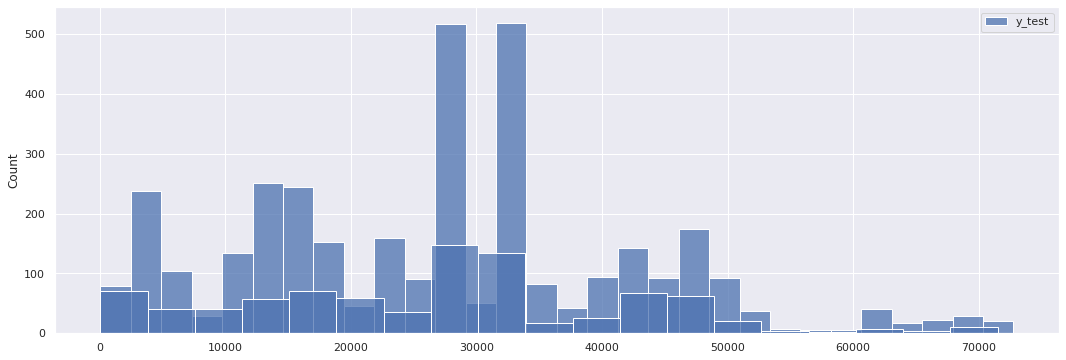

In [15]:
import pandas as pd
import seaborn as sns

plt.figure(figsize=(18, 6))
sns.histplot(pd.DataFrame({'y_train':y_train})), sns.histplot(pd.DataFrame({'y_test':y_test}))

In [16]:
sent_emb = 768
batch_size = 256
lr = 1e-3
EPOCHS = 100
alpha = 0.2 

tgen = TripletGenerator()
train_generator = tgen.generate_triplets(X_train, y_train, batch_size)
test_generator = tgen.generate_triplets(X_test, y_test, batch_size)

labels = np.unique(np.concatenate([y_train, y_test]))

In [17]:
X_train[4]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2429,
        292,    5,  196, 2430], dtype=int32)

In [18]:
next(train_generator)

([array([[  0.,   0.,   0., ...,   0.,   0., 109.],
         [  0.,   0.,   0., ...,   0.,   0.,  11.],
         [  0.,   0.,   0., ...,   0.,  27., 455.],
         ...,
         [  0.,   0.,   0., ...,  11.,  10.,  80.],
         [  0.,   0.,   0., ...,   0.,   0.,  11.],
         [  0.,   0.,   0., ...,   0.,   0.,  11.]], dtype=float32),
  array([[  0.,   0.,   0., ...,   0.,   0., 109.],
         [  0.,   0.,   0., ...,   6., 145., 203.],
         [  0.,   0.,   0., ...,   0.,   0.,  95.],
         ...,
         [  0.,   0.,   0., ..., 260.,  11., 223.],
         [  0.,   0.,   0., ...,   0.,   0.,  11.],
         [  0.,   0.,   0., ...,   0.,   0.,  11.]], dtype=float32),
  array([[   0.,    0.,    0., ...,    0.,    0.,  988.],
         [   0.,    0.,    0., ...,    0.,  165.,  188.],
         [   0.,    0.,    0., ...,    0.,   27.,  109.],
         ...,
         [   0.,    0.,    0., ...,    8., 1331.,  472.],
         [   0.,    0.,    0., ...,  139.,   14., 1098.],
         [

In [19]:


# emb_model = base_model(sent_emb)
# model = siamese_model(emb_model, sent_emb, triplet_loss, identity_loss, learning_rate=lr)

emb_model = base_model_lstm(embedding_matrix)
model = siamese_model_lstm(emb_model, triplet_loss, identity_loss, learning_rate=lr)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 750)          337778      input_1[0][0]                    
                                                                 input_2[0][0]                

In [20]:
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=15,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=EPOCHS, 
                              verbose=1, 
                              workers=10,
                              use_multiprocessing=True,
                              steps_per_epoch=20, 
                              validation_steps=10,
                             callbacks=[early_stopping_callback])

Epoch 1/100
20/20 [==============================] - 21s 712ms/step - loss: 0.5517 - val_loss: 0.3313
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 0.3986

Process Keras_worker_ForkPoolWorker-15:
Process Keras_worker_ForkPoolWorker-14:
Process Keras_worker_ForkPoolWorker-13:
Process Keras_worker_ForkPoolWorker-16:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 93, in ru

Traceback (most recent call last):
KeyboardInterrupt
KeyboardInterrupt
  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 77, in get_triplet
    probs = np.array([y[y==cls].shape[0]/y.shape[0] for cls in y])
Traceback (most recent call last):
  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 77, in <listcomp>
    probs = np.array([y[y==cls].shape[0]/y.shape[0] for cls in y])
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kaigorodov/

  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 77, in get_triplet
    probs = np.array([y[y==cls].shape[0]/y.shape[0] for cls in y])
  File "/home/kaigorodov/.local/lib/python3.6/site-packages/tensorflow/python/keras/utils/data_utils.py", line 831, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 77, in <listcomp>
    probs = np.array([y[y==cls].shape[0]/y.shape[0] for cls in y])
  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 96, in generate_triplets
    a, p, n = self.get_triplet(X, y)
KeyboardInterrupt
  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 77, in get_triplet
    probs = np.array([y[y==cls].shape[0]/y.shape[0] for cls in y])
  File "/home/kaigorodov/myprojects/MedConcNorm/src/support_models/triplet_generator.py", line 77, in <listc

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
X_train_trm = emb_model.predict(X_train.reshape(-1, sent_emb, 1))
X_test_trm = emb_model.predict(X_test.reshape(-1, sent_emb, 1))
X_train.shape, X_train_trm.shape, X_test.shape, X_test_trm.shape

# Show changes

In [ ]:
def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 500))
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40, c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

In [ ]:
# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne = tsne.fit_transform(X_train)
print(train_tsne.shape, y_train.shape)
scatter(train_tsne, y_train)

In [ ]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)
print(train_tsne_embeds.shape, y_train.shape)
scatter(train_tsne_embeds, y_train)

In [ ]:
tsne = TSNE()
test_tsne = tsne.fit_transform(X_test)
print(test_tsne.shape, y_test.shape)
scatter(test_tsne, y_test)

In [ ]:
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)
print(test_tsne_embeds.shape, y_test.shape)
scatter(test_tsne_embeds, y_test)

In [ ]:
tsne = TSNE(n_components=3)
train_to_classify = tsne.fit_transform(X_train_trm)
test_to_classify = tsne.fit_transform(X_test_trm)

train_to_classify.shape, test_to_classify.shape

# Classify

In [ ]:
import pandas as pd
import numpy as np
from copy import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pymedtermino

from metric_learn import NCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from tpot import TPOTClassifier

generations = 3
population_size = 20
max_eval_time_mins = 1
n_jobs = 10
max_iter = 10

tpot = TPOTClassifier(generations=generations, 
                      population_size=population_size,
                      verbosity=2, 
                      random_state=42, 
                      max_eval_time_mins=max_eval_time_mins, 
                      n_jobs=n_jobs)

tpot.fit(train_tsne_embeds, y_train)

In [ ]:
score = tpot.score(train_tsne_embeds, y_train)
score

In [ ]:
score = tpot.score(test_tsne_embeds, y_test)
score

score was with low alpha = 0.17439703153988867
score was with 0.2 alpha = 0.11873840445269017

In [ ]:
y = np.array([2, 3 , 4, 5, 1, 2, 0 ,1, 2])
d = np.array([324, 656, 55453, 2342, 5464, 3244, 23, 545, 23243])

y[np.argmin(d)]

In [ ]:
y = np.array([1, 2, 2, 1, 0 ,0 ,0, 1]*3)
d = np.array([2333, 232, 13423, 32423 ,234324, 234, 4545, 23]*3)

np.argpartition(d, y.shape[0]-1)[:], y[np.argpartition(d, y.shape[0]-1)[:]]

In [ ]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((10,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(y_train, 10)[:sample_size]
Y_test_onehot = np_utils.to_categorical(y_test, 10)[:sample_size]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=10)

In [ ]:
# from google.colab import files
# import io
# uploaded = files.upload()


In [ ]:
# def gini(x):
#     # calculates the gini coeffiecent of 
#     # an array. 
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     rmad = mad/np.mean(x)
#     g = 0.5 * rmad
#     return g

# def DigitOrNumber(x):
#   # Creates an embedding for an image and then calculates the 
#   # equality of the softmax prediction distribution if it is below a certain threshold
#   # then the image will be classified as a digit
#   temp = base_model.predict(x)
#   temp = Classifier_model.predict(temp)
#   if gini(temp) < 0.87:
#     print(np.argmax(temp))
#   else:
#     print('Input is not a Digit')
    
# # a few examples
# x= np.load(io.BytesIO(uploaded['emnist_train_images_3 (1).npy'])) 
# DigitOrNumber(x[0:1])
# DigitOrNumber(x[1:2])
# DigitOrNumber(x[2:3])
# DigitOrNumber(X_test[20:21])
# DigitOrNumber(X_test[500:501])
# DigitOrNumber(X_test[1007:1008])